In [1]:
from mnist import MNIST
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np 
import cv2 
from collections import deque 
import time
import os
from keras.models import load_model


THRESHOLD_PROBABILITY = 0.95

def isValid(prediction):
    prob = max(prediction)
    print(prob)
    return prob > THRESHOLD_PROBABILITY

def create_model():
    model = Sequential()
    model.add(Input(shape = (28, 28))) # input layer
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512, activation='relu')) # hidden layer
    model.add(Dropout(0.2)) # prevent overfitting
    model.add(Dense(512, activation='relu')) # hidden layer
    model.add(Dropout(0.2)) # prevent overfitting
    model.add(Dense(26, activation='softmax')) # output layer
    return model

def train_model():
    print('--------- Training New Model -----------')
    data = MNIST(path='data/', return_type='numpy')
    data.select_emnist('letters')
    X, y = data.load_training()
    
    X = X.reshape(124800, 28, 28)
    y = y.reshape(124800, 1)
    
    y = y - 1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    
    y_train = to_categorical(y_train, num_classes = 26)
    y_test = to_categorical(y_test, num_classes = 26)

    checkpoint_weights_path = 'best_model.keras'

    model = create_model()
    model.summary()
    model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath = checkpoint_weights_path, verbose = 1, save_best_only = True)
    
    model.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_split = 0.2, callbacks = [checkpointer], verbose = 1, 
              shuffle = True)
    print('Model saved successfully : best_model.keras')
    

training = input("Do you want to train a new model? Press (Y) for Yes else (N) for No")

if training == 'Y':
    train_model()

model = load_model('best_model_adam.keras')


def color_detector():
    def setValues(x):
        print("")
    # creating a window for HUE selector
    cv2.namedWindow("Color detectors") 
    cv2.createTrackbar("Upper Hue", "Color detectors", 153, 180, setValues) 
    cv2.createTrackbar("Upper Saturation", "Color detectors", 255, 255, setValues) 
    cv2.createTrackbar("Upper Value", "Color detectors", 255, 255, setValues) 
    cv2.createTrackbar("Lower Hue", "Color detectors", 64, 180, setValues) 
    cv2.createTrackbar("Lower Saturation", "Color detectors", 72, 255, setValues) 
    cv2.createTrackbar("Lower Value", "Color detectors", 49, 255, setValues)



color_detector() 

def prediction_from_image(image_save_path):
    # Dictionary for getting characters from index values...
    word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}
    
    img = cv2.imread(image_save_path)
    img_copy = img.copy()
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, (400,440))
    
    img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    _, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)
    
    img_final = cv2.resize(img_thresh, (28,28))
    img_final =np.reshape(img_final, (1,28,28,1))
    img_pred = word_dict[np.argmax(model.predict(img_final))]
    return img_pred
    
image_save_path = os.path.join(os.getcwd(), "last_frame.jpg")


bpoints = [deque(maxlen = 512)] 
gpoints = [deque(maxlen = 512)] 
ypoints = [deque(maxlen = 512)] 
rpoints = [deque(maxlen = 512)] 

# Now to mark the pointers in the above colour array we introduce some index values Which would mark their positions  

blue_index = 0
green_index = 0
yellow_index = 0
red_index = 0

# The kernel is used for dilation of contour

kernel = np.ones((5, 5)) 

# The ink colours for the drawing purpose 
 
colors = [(255, 0, 0), (0, 255, 0), (0, 225, 255), (0, 0, 255)] 
colorIndex = 0

# Setting up the drawing board AKA The canvas 

paintWindow = np.zeros((1500, 1500, 3)) + 255

cv2.namedWindow('Paint', cv2.WINDOW_AUTOSIZE) 
 
cap = cv2.VideoCapture(0) 
prediction = 'NA'
while True: 

    # Reading the camera frame 
    ret, frame = cap.read() 
    # For saving
    # out = cv2.VideoWriter("Paint-Window.mp4", cv2.VideoWriter_fourcc(*'XVID'), 1, (frame.shape[1], frame.shape[0]))
    
    # Flipping the frame to see same side of the user  
    frame = cv2.flip(frame, 1) 
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 

    # Getting the new positions of the trackbar and setting the new HSV values 

    u_hue = cv2.getTrackbarPos("Upper Hue", "Color detectors") 
    u_saturation = cv2.getTrackbarPos("Upper Saturation", "Color detectors") 
    u_value = cv2.getTrackbarPos("Upper Value","Color detectors") 
    l_hue = cv2.getTrackbarPos("Lower Hue", "Color detectors") 
    l_saturation = cv2.getTrackbarPos("Lower Saturation", "Color detectors") 
    l_value = cv2.getTrackbarPos("Lower Value", "Color detectors") 
    Upper_hsv = np.array([u_hue, u_saturation, u_value]) 
    Lower_hsv = np.array([l_hue, l_saturation, l_value]) 

    # Adding the colour buttons to the live frame to choose color
    frame = cv2.rectangle(frame, (35, 1), (135, 65), (122, 122, 122), -1) 
    frame = cv2.rectangle(frame, (160, 1), (255, 65), (255, 0, 0), -1) 
    frame = cv2.rectangle(frame, (275, 1), (370, 65), (0, 255, 0), -1) 
    frame = cv2.rectangle(frame, (390, 1), (485, 65), (0, 255, 255), -1) 
    frame = cv2.rectangle(frame, (505, 1), (600, 65), (0, 0, 255), -1) 

    cv2.putText(frame, "Clear All", (55, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Blue Color", (175, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 
    
    cv2.putText(frame, "Green Color", (285, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Yellow Color", (400, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Red Color", (520, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 


    # masking out the pointer for it's identification in the frame 

    Mask = cv2.inRange(hsv, Lower_hsv, Upper_hsv) 
    Mask = cv2.erode(Mask, kernel, iterations = 1) 
    Mask = cv2.morphologyEx(Mask, cv2.MORPH_OPEN, kernel) 
    Mask = cv2.dilate(Mask, kernel, iterations = 1) 

    # Now contouring the pointers post identification 
    lower_red = np.array([100,60,60])
    upper_red = np.array([140,255,255])
    lower_green = np.array([80, 140, 110]) 
    upper_green = np.array([90, 160, 125])
    red_mask = cv2.inRange(hsv, lower_red, upper_red)
    red_mask = cv2.erode(red_mask, kernel, iterations=1)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_mask = cv2.dilate(red_mask, kernel, iterations=1)

    countours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centre = None

    # If there are any contours formed 
    if len(countours) > 0: 
        
        # sorting the contours for the biggest 
        countour = sorted(countours, key = cv2.contourArea, reverse = True)[0] 
        # Get the radius of the cirlce formed around the found contour   
        ((x, y), radius) = cv2.minEnclosingCircle(countour) 
        
        # Drawing the circle boundary around the contour 
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2) 
        
        # Calculating the centre of the detected contour 
        M = cv2.moments(countour) 
        centre = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])) 
        
        # Now checking if the user clicked on another button on the screen (the 4 buttons that were mentioned Y,G,B,R and clear all)
        if centre[1] <= 65: 
            
            # Clear Button 
            if 35 <= centre[0] <= 135: 
                bpoints = [deque(maxlen = 512)] 
                gpoints = [deque(maxlen = 512)] 
                ypoints = [deque(maxlen = 512)] 
                rpoints = [deque(maxlen = 512)] 

                blue_index = 0
                green_index = 0
                yellow_index = 0
                red_index = 0

                paintWindow[:, :, :] = 255
            elif 160 <= centre[0] and centre[0] <= 255: 
                colorIndex = 0 # Blue 
                    
            elif 275 <= centre[0] and centre[0] <= 370: 
                colorIndex = 1 # Green 
            elif 390 <= centre[0] and centre[0] <= 485: 
                colorIndex = 2 # Yellow
            elif 505 <= centre[0] and centre[0] <= 600: 
                colorIndex = 3 # Red 
        else : 
            if colorIndex == 0: 
                bpoints[blue_index].appendleft(centre) 
            elif colorIndex == 1: 
                gpoints[green_index].appendleft(centre) 
            elif colorIndex == 2: 
                ypoints[yellow_index].appendleft(centre) 
            elif colorIndex == 3: 
                rpoints[red_index].appendleft(centre) 
                
    # Appending the next deques if nothing is detected

    else: 
        bpoints.append(deque(maxlen = 512)) 
        blue_index += 1
        gpoints.append(deque(maxlen = 512)) 
        green_index += 1
        ypoints.append(deque(maxlen = 512)) 
        yellow_index += 1
        rpoints.append(deque(maxlen = 512)) 
        red_index += 1

    # Drawing the lines of every colour on the canvas and the track frame window
    
    points = [bpoints, gpoints, ypoints, rpoints] 
    for i in range(len(points)): 
        for j in range(len(points[i])): 
            for k in range(1, len(points[i][j])): 
                if points[i][j][k - 1] is None or points[i][j][k] is None: 
                    continue
                    
                cv2.line(frame, points[i][j][k - 1], points[i][j][k], colors[i], 25) 
                cv2.line(paintWindow, points[i][j][k - 1], points[i][j][k], colors[i], 25) 

    key = cv2.waitKey(1)    

    # letter_predictor = LetterPredictor()        
    if key & 0xFF == ord('v'):  
        print("user pressed v")        
        cv2.imwrite(image_save_path, paintWindow)
        prediction = prediction_from_image(image_save_path)

    # letter_predictor = LetterPredictor()        
    if key & 0xFF == ord('c'): 
        print("user pressed c")          
        bpoints = [deque(maxlen = 512)] 
        gpoints = [deque(maxlen = 512)] 
        ypoints = [deque(maxlen = 512)] 
        rpoints = [deque(maxlen = 512)] 
        blue_index = 0
        green_index = 0
        yellow_index = 0
        red_index = 0
        paintWindow[:, :, :] = 255
        
    cv2.putText(frame, "Prediction: " + str(prediction), (800,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,102,0), 8)
    cv2.putText(frame, "V to predict", (800,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    cv2.putText(frame, "C to Clear", (800,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    cv2.putText(frame, "Q to Quit", (800,400), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    
    # Displaying/running all the 3 windows 
    cv2.imshow("Live Tracking", frame) 
    cv2.imshow("Paint", paintWindow) 
    # cv2.imshow("mask", Mask) 
    
    # For quitting/breaking the loop - press and hold ctrl+q twice 
    if key & 0xFF == ord("q"): 
        print("user pressed Q")
        break

# Releasing the camera and all the other resources of the device  
cap.release() 
cv2.destroyAllWindows() 
cv2.waitKey(1) 







user pressed c
user pressed v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
user pressed v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
user pressed c
user pressed v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
user pressed v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
user pressed c
user pressed c
user pressed Q


-1

In [11]:
import pandas as pd

In [12]:
# Read the data...
data = pd.read_csv(r"a_z_handwritten_data.csv").astype('float32')

In [13]:
# Split data the X - Our data , and y - the prdict label
X = data.drop('0',axis = 1)
y = data['0']

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

In [15]:
# Reshaping the data in csv file so that it can be displayed as an image...

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)
train_x = np.reshape(train_x.values, (train_x.shape[0], 28,28))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28,28))


print("Train data shape: ", train_x.shape)
print("Test data shape: ", test_x.shape)

Train data shape:  (297960, 28, 28)
Test data shape:  (74490, 28, 28)


In [16]:
# Dictionary for getting characters from index values...

word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}

In [17]:

import matplotlib.pyplot as plt

/var/folders/xp/prhddszn5zq2zgk4bth_djh40000gn/T/ipykernel_2255/1695428118.py:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  train_yint = np.int0(y)


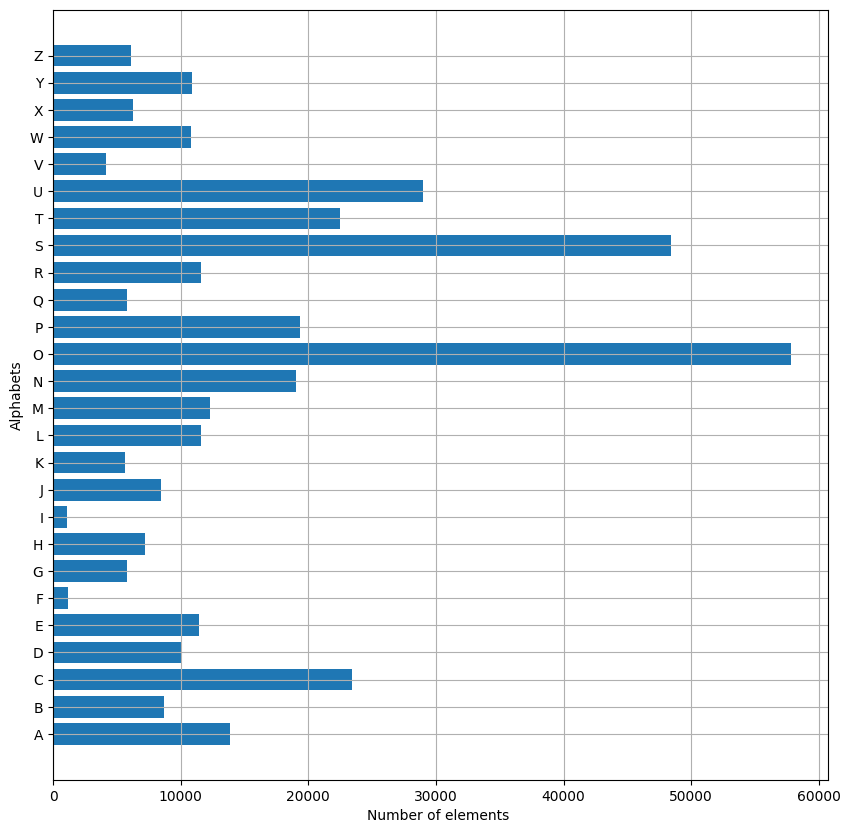

<Figure size 640x480 with 0 Axes>

In [18]:
# Plotting the number of alphabets in the dataset...

train_yint = np.int0(y)
count = np.zeros(26, dtype='int')
for i in train_yint:
    count[i] +=1

alphabets = []
for i in word_dict.values():
    alphabets.append(i)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, count)

plt.xlabel("Number of elements ")
plt.ylabel("Alphabets")
plt.grid()
plt.show()
plt.savefig(fname='graph')

In [19]:
from sklearn.utils import shuffle

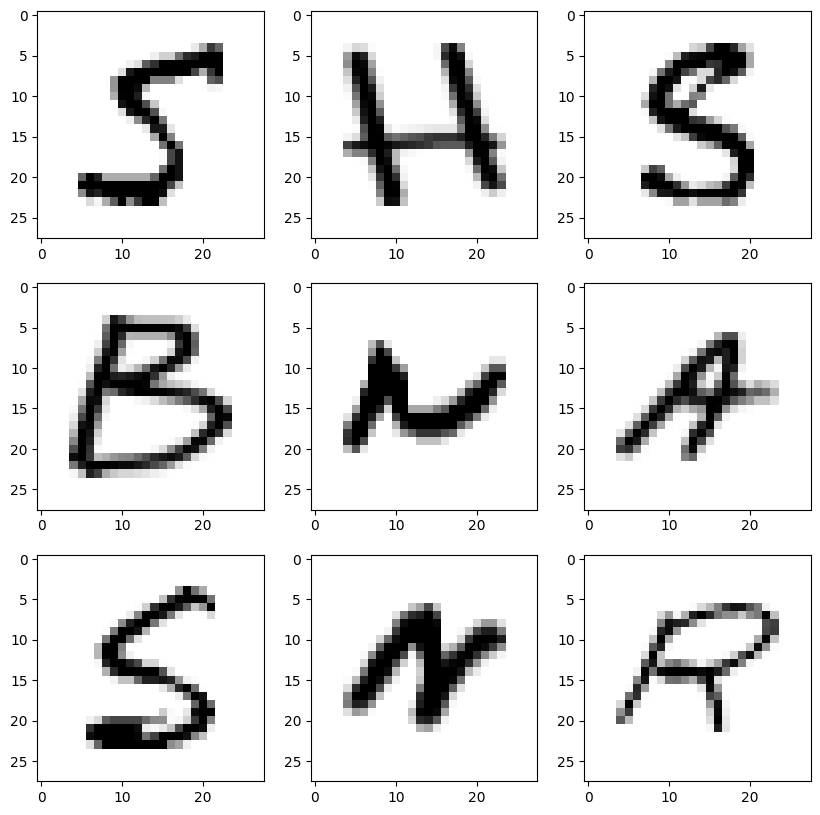

In [20]:
# Shuffling the data ...
shuff = shuffle(train_x[:100])

fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()

for i in range(9):
    axes[i].imshow(np.reshape(shuff[i], (28,28)), cmap="Greys")
plt.show()

In [21]:
# Reshaping the training & test dataset so that it can be put in the model...

train_X = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
print("New shape of train data: ", train_X.shape)

test_X = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2],1)
print("New shape of test data: ", test_X.shape)

New shape of train data:  (297960, 28, 28, 1)
New shape of test data:  (74490, 28, 28, 1)


In [22]:
from keras.utils import to_categorical

In [23]:
# Converting the labels to categorical values...

train_yOHE = to_categorical(train_y, num_classes = 26)
print("New shape of train labels: ", train_yOHE.shape)

test_yOHE = to_categorical(test_y, num_classes = 26)
print("New shape of test labels: ", test_yOHE.shape)

New shape of train labels:  (297960, 26)
New shape of test labels:  (74490, 26)


In [24]:
# Choosing whether to train the model or not

Training = False # Change this to False if you want to use trained model after initial training

In [25]:
from mnist import MNIST
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np 
import cv2 
from collections import deque 
import time
import os
from keras.models import load_model

In [26]:
# CNN model...
if Training == True:
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())

    model.add(Dense(64,activation ="relu"))
    model.add(Dense(128,activation ="relu"))

    model.add(Dense(26,activation ="softmax"))



    # model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


    history = model.fit(train_X, train_yOHE, epochs= 4, callbacks=[reduce_lr, early_stop],  validation_data = (train_X, train_yOHE))


    model.summary()
    model.save(r'Alphabet_Recognition.keras')

    # Displaying the accuracies & losses for train & validation set...

    print("The validation accuracy is :", history.history['val_accuracy'])
    print("The training accuracy is :", history.history['accuracy'])
    print("The validation loss is :", history.history['val_loss'])
    print("The training loss is :", history.history['loss'])
    
else:
    model = load_model(r'Alphabet_Recognition.keras')
    

In [27]:

pred = model.predict(test_X[:9])
print(test_X.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
(74490, 28, 28, 1)


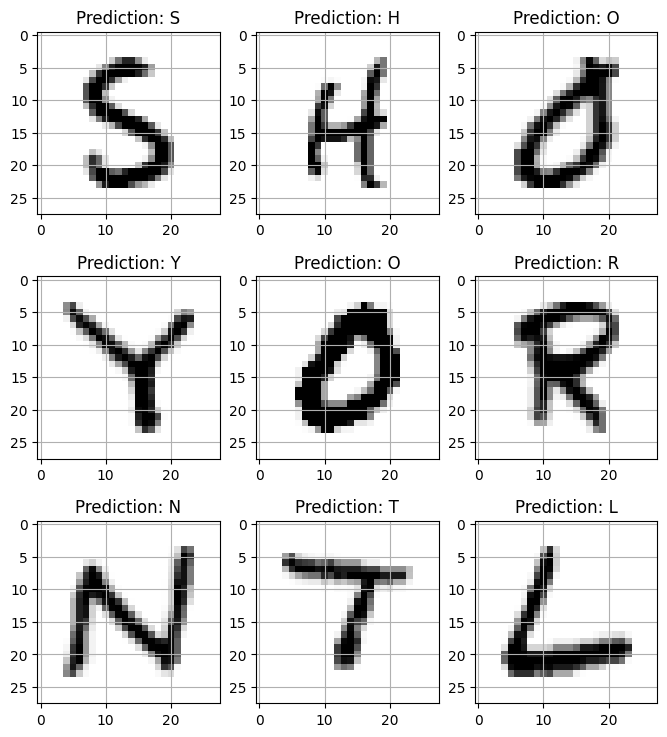

In [23]:
# Displaying some of the test images & their predicted labels...

fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(test_X[i], (28,28))
    ax.imshow(img, cmap="Greys")
    pred = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [29]:
labels = {'A': 0,'B': 1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23, 'Y':24,'Z':25}

In [30]:
pred_test = model.predict(test_X)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 127s 55ms/step


In [31]:
pred_test.shape

(74490, 26)

<Axes: >

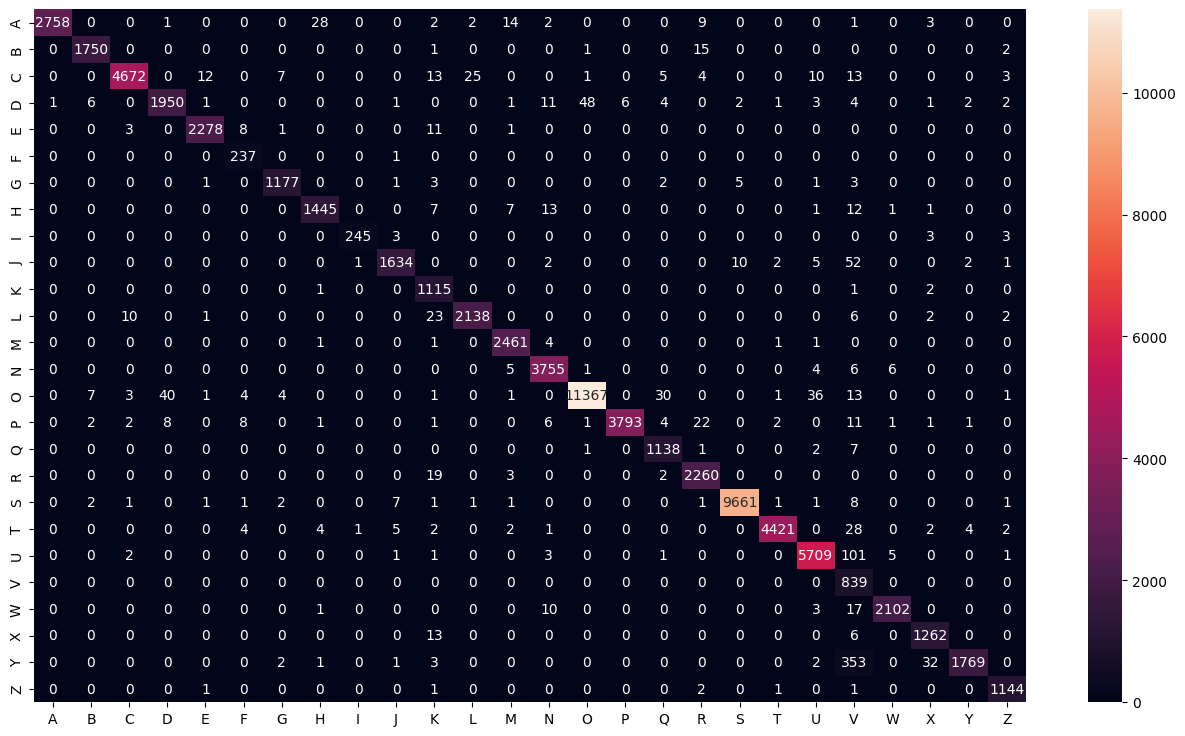

In [32]:
plt.figure(figsize= (16, 9))
y_pred_labels = [np.argmax(labels) for labels in pred_test]
cm = confusion_matrix(test_y, y_pred_labels)

sns.heatmap(cm, annot = True, fmt = 'd', xticklabels= labels, yticklabels= labels)

In [33]:
pred_train = model.predict(train_X)

9312/9312 ━━━━━━━━━━━━━━━━━━━━ 548s 59ms/step


In [34]:
train_X.shape

(297960, 28, 28, 1)

In [35]:
pred_train.shape

(297960, 26)

<Axes: >

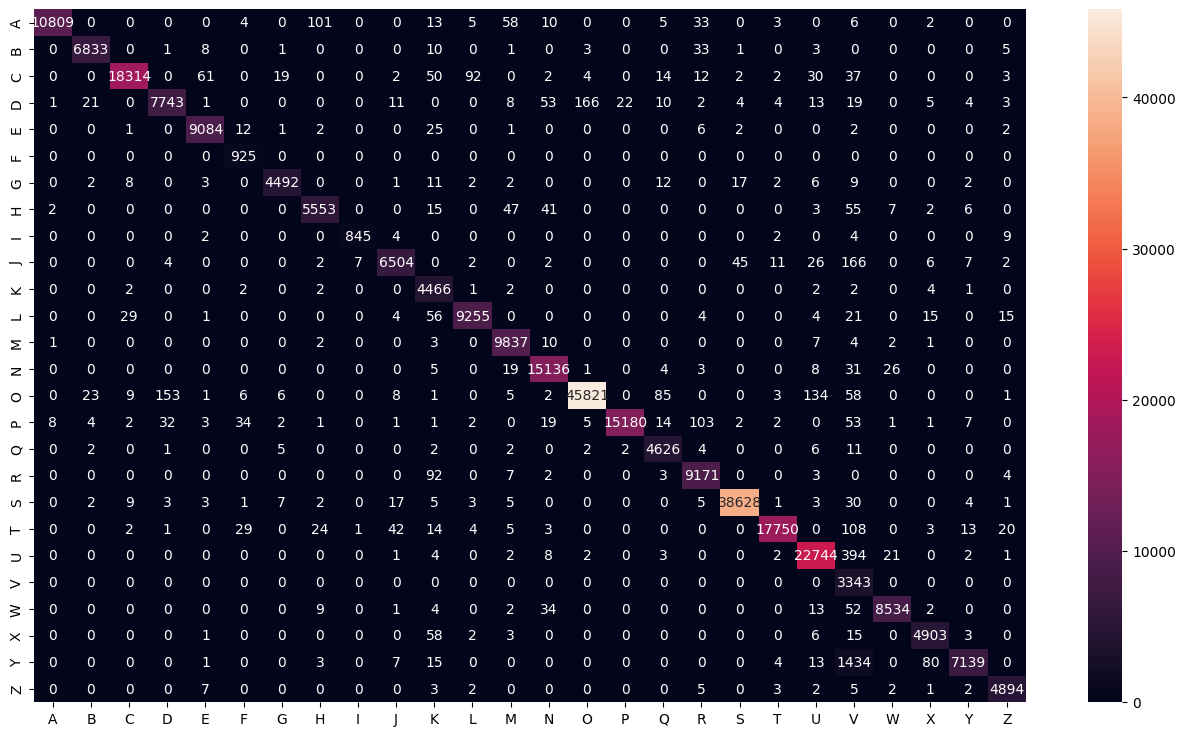

In [36]:
plt.figure(figsize= (16, 9))
y_pred_labels = [np.argmax(labels) for labels in pred_train]
cm = confusion_matrix(train_y, y_pred_labels)

sns.heatmap(cm, annot = True, fmt = 'd', xticklabels= labels, yticklabels= labels)

In [ ]:
# Choose between training:

Training = True

In [ ]:
# CNN model using ADAM optimzer
if Training == True:
    model_a = Sequential()

    model_a.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model_a.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_a.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model_a.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_a.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model_a.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_a.add(Flatten())

    model_a.add(Dense(64,activation ="relu"))
    model_a.add(Dense(128,activation ="relu"))

    model_a.add(Dense(26,activation ="softmax"))



    # model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model_a.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


    history_train = model_a.fit(train_X, train_yOHE, epochs= 4, callbacks=[reduce_lr, early_stop],  validation_data = (train_X, train_yOHE))
    history_test = model_a.fit(test_X, test_yOHE, epochs= 4, callbacks=[reduce_lr, early_stop],  validation_data = (test_X, test_yOHE))

    model_a.summary()
    model_a.save(r'best_model_adam.keras')

    
else:
    model_a = load_model(r'best_model_adam.keras')

In [ ]:
# CNN model using RMSProp as optimizer...
if Training == True:
    model_r = Sequential()

    model_r.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model_r.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_r.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model_r.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_r.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model_r.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_r.add(Flatten())

    model_r.add(Dense(64,activation ="relu"))
    model_r.add(Dense(128,activation ="relu"))

    model_r.add(Dense(26,activation ="softmax"))



    model_r.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


    history_train2 = model_r.fit(train_X, train_yOHE, epochs= 4, callbacks=[reduce_lr, early_stop],  validation_data = (train_X, train_yOHE))
    history_test2 = model_r.fit(test_X, test_yOHE, epochs= 4, callbacks=[reduce_lr, early_stop],  validation_data = (test_X, test_yOHE))

    model_r.summary()
    model_r.save(r'best_model_rmsprop.keras')

    
else:
    model_r = load_model(r'best_model_rmsprop.keras')


In [ ]:
metrics = ['loss', 'accuracy']

In [ ]:
plt.figure(figsize=(10, 4))
#Use "For Loop".
for i in range(len(metrics)):
    metric = metrics[i]
    #set subplots to show the result
    plt.subplot(1, 2, i+1)
    #Titles of subplots are "loss" and "accuracy"
    plt.title(metric) 
    plt_train1 = history_train.history[metric] 
    plt_test1 = history_test.history[metric]
    plt_train2 = history_train2.history[metric]
    plt_test2 = history_test2.history[metric] 
    #plot them all
    plt.plot(plt_train1, label='train1')
    plt.plot(plt_test1, label='test1')
    plt.plot(plt_train2, label='train2')
    plt.plot(plt_test2, label='test2')
    plt.legend()
plt.show()

In [3]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split as tts
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
from collections import deque 
import time
import os
from keras.models import load_model

training = input("Do you want to train a new model? Press (Y) for Yes else (N) for No")

alpha = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

def generate_model():
    model = Sequential([Conv2D(128,(3,3),activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1),padding='same'),
                    Conv2D(64,(3,3),activation='relu', kernel_initializer='he_uniform',padding='same'),
                    MaxPooling2D(2,2),
                    Conv2D(64,(3,3),activation='relu', kernel_initializer='he_uniform',padding='same'),
                    Conv2D(64,(3,3),activation='relu', kernel_initializer='he_uniform',padding='same'),
                    BatchNormalization(),
                    MaxPooling2D(2,2),
                    Flatten(),
                    Dense(100,activation='relu',kernel_initializer='he_uniform'),
                    Dropout(0.1),
                    Dense(64,activation='relu',kernel_initializer='he_uniform'),
                    Dropout(0.125),
                    BatchNormalization(),
                    Dense(26,activation='softmax')])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9),
                  metrics=['accuracy'])
    model.summary() 
    return model

def train():
    
    df=pd.read_csv('a_z_handwritten_data.csv')
    data_array = np.array(df,dtype=np.uint8)
    del df  #memory issues
    
    labels = data_array[:,0]
    x = data_array[:,1:].reshape(372450,28,28)/255.
    del data_array
    unique, counts = np.unique(labels, return_counts=True)
    list_alpha = list(zip(alpha, counts))

    fig=plt.figure(figsize=(15,6))
    plt.xlabel('ALPHABETS',fontsize=14)
    plt.ylabel('COUNT',fontsize=14)
    plt.bar(alpha,counts)

    a = np.random.randint(low=0,high=372449,size=10)
    fig=plt.figure(figsize=(30,30))
    c=1
    for i in a:
        fig.add_subplot(20,20,c)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x[i],cmap='gray')
        c+=1
        
    del a   # cleaning
    del c, list_alpha, counts, unique # cleaning

    x=x.reshape(372450,28,28,1)
    x_train,x_test,y_train,y_test = tts(x,labels,test_size=0.01)
    del x  # memory issues
    del labels

    model = generate_model()
    history = model.fit(x=x_train,y=y_train,validation_split=0.1,epochs=5)
    
    val_loss=history.history['val_loss']
    val_accuracy=history.history['val_accuracy']
    loss=history.history['loss']
    accuracy=history.history['accuracy']

    fig=plt.figure(figsize=(10,15))
    fig.add_subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(loss, color='blue', label='train')
    plt.plot(val_loss, color='red', label='test')
    plt.legend()
    # plot accuracy
    fig.add_subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(accuracy, color='blue', label='train')
    plt.plot(val_accuracy, color='red', label='test')
    plt.legend()

    metrics=model.evaluate(x_test,y_test)
    metrics

    model.save('Alphabet_Recognition.keras')

if training == 'Y':
    train()

model = load_model('Alphabet_Recognition.keras')


def color_detector():
    def setValues(x):
        print("")
    # creating a window for HUE selector
    cv2.namedWindow("Color detectors") 
    cv2.createTrackbar("Upper Hue", "Color detectors", 153, 180, setValues) 
    cv2.createTrackbar("Upper Saturation", "Color detectors", 255, 255, setValues) 
    cv2.createTrackbar("Upper Value", "Color detectors", 255, 255, setValues) 
    cv2.createTrackbar("Lower Hue", "Color detectors", 64, 180, setValues) 
    cv2.createTrackbar("Lower Saturation", "Color detectors", 72, 255, setValues) 
    cv2.createTrackbar("Lower Value", "Color detectors", 49, 255, setValues)

def alphabet_recognize(filepath):
    image = cv2.imread(filepath)
    blur_image=cv2.medianBlur(image,7)

    grey = cv2.cvtColor(blur_image, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(grey,200,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,41,25)

    contours,hierarchy= cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    preprocessed_digits = []

    # initialize the reverse flag and sort index
    # handle if we need to sort in reverse
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
                                    key=lambda b:b[1][0], reverse=False))


    for c in contours:
        x,y,w,h = cv2.boundingRect(c)

        # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
        cv2.rectangle(blur_image, (x,y), (x+w, y+h), color=(255, 0, 0), thickness=2)

        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit = thresh[y:y+h, x:x+w]

        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (18,18))

        # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)

        # Adding the preprocessed digit to the list of preprocessed digits
        preprocessed_digits.append(padded_digit)

    inp = np.array(preprocessed_digits)
    i=1
    alphabets=[]
    invalid_alphabets=[]
    for digit in preprocessed_digits:
        [prediction] = model.predict(digit.reshape(1, 28, 28, 1)/255.)
        if not isValid(prediction):
            invalid_alphabets.append(alpha[np.argmax(prediction)])
        pred=alpha[np.argmax(prediction)]
        alphabets.append(pred)
        i+=1
        
    print("The Recognized Alphabets are : " ,*alphabets)
    print("The Invalid Alphabets are : " ,*invalid_alphabets)
    if(len(invalid_alphabets) > 0):
        return "invalid"
    return "".join(alphabets)


image_save_path = os.path.join(os.getcwd(), "last_frame.jpg")
color_detector()

bpoints = [deque(maxlen = 512)] 
gpoints = [deque(maxlen = 512)] 
ypoints = [deque(maxlen = 512)] 
rpoints = [deque(maxlen = 512)] 

# Now to mark the pointers in the above colour array we introduce some index values Which would mark their positions  

blue_index = 0
green_index = 0
yellow_index = 0
red_index = 0

# The kernel is used for dilation of contour

kernel = np.ones((5, 5)) 

# The ink colours for the drawing purpose 
 
colors = [(255, 0, 0), (0, 255, 0), (0, 225, 255), (0, 0, 255)] 
colorIndex = 0

# Setting up the drawing board AKA The canvas 

paintWindow = np.zeros((1500, 1500, 3)) + 255

cv2.namedWindow('Paint', cv2.WINDOW_AUTOSIZE) 
 
cap = cv2.VideoCapture(0) 
prediction = 'NA'

pause =False

while True: 

    # Reading the camera frame 
    ret, frame = cap.read() 
    # For saving
    # out = cv2.VideoWriter("Paint-Window.mp4", cv2.VideoWriter_fourcc(*'XVID'), 1, (frame.shape[1], frame.shape[0]))
    
    # Flipping the frame to see same side of the user  
    frame = cv2.flip(frame, 1) 
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 

    # Getting the new positions of the trackbar and setting the new HSV values 

    u_hue = cv2.getTrackbarPos("Upper Hue", "Color detectors") 
    u_saturation = cv2.getTrackbarPos("Upper Saturation", "Color detectors") 
    u_value = cv2.getTrackbarPos("Upper Value","Color detectors") 
    l_hue = cv2.getTrackbarPos("Lower Hue", "Color detectors") 
    l_saturation = cv2.getTrackbarPos("Lower Saturation", "Color detectors") 
    l_value = cv2.getTrackbarPos("Lower Value", "Color detectors") 
    Upper_hsv = np.array([u_hue, u_saturation, u_value]) 
    Lower_hsv = np.array([l_hue, l_saturation, l_value]) 

    # Adding the colour buttons to the live frame to choose color
    frame = cv2.rectangle(frame, (35, 1), (135, 65), (122, 122, 122), -1) 
    frame = cv2.rectangle(frame, (160, 1), (255, 65), (255, 0, 0), -1) 
    frame = cv2.rectangle(frame, (275, 1), (370, 65), (0, 255, 0), -1) 
    frame = cv2.rectangle(frame, (390, 1), (485, 65), (0, 255, 255), -1) 
    frame = cv2.rectangle(frame, (505, 1), (600, 65), (0, 0, 255), -1) 

    cv2.putText(frame, "Clear All", (55, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Blue Color", (175, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 
    
    cv2.putText(frame, "Green Color", (285, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Yellow Color", (400, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Red Color", (520, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 


    # masking out the pointer for it's identification in the frame 

    Mask = cv2.inRange(hsv, Lower_hsv, Upper_hsv) 
    Mask = cv2.erode(Mask, kernel, iterations = 1) 
    Mask = cv2.morphologyEx(Mask, cv2.MORPH_OPEN, kernel) 
    Mask = cv2.dilate(Mask, kernel, iterations = 1) 

    # Now contouring the pointers post identification 
    lower_red = np.array([100,60,60])
    upper_red = np.array([140,255,255])
    red_mask = cv2.inRange(hsv, lower_red, upper_red)
    red_mask = cv2.erode(red_mask, kernel, iterations=1)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_mask = cv2.dilate(red_mask, kernel, iterations=1)

    countours=[]
    if pause==False:
        countours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    centre = None

    # If there are any contours formed 
    if len(countours) > 0: 
        
        # sorting the contours for the biggest 
        countour = sorted(countours, key = cv2.contourArea, reverse = True)[0] 
        # Get the radius of the cirlce formed around the found contour   
        ((x, y), radius) = cv2.minEnclosingCircle(countour) 
        
        # Drawing the circle boundary around the contour 
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2) 
        
        # Calculating the centre of the detected contour 
        M = cv2.moments(countour) 
        centre = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])) 
        
        # Now checking if the user clicked on another button on the screen (the 4 buttons that were mentioned Y,G,B,R and clear all)
        if centre[1] <= 65: 
            
            # Clear Button 
            if 35 <= centre[0] <= 135: 
                bpoints = [deque(maxlen = 512)] 
                gpoints = [deque(maxlen = 512)] 
                ypoints = [deque(maxlen = 512)] 
                rpoints = [deque(maxlen = 512)] 

                blue_index = 0
                green_index = 0
                yellow_index = 0
                red_index = 0

                paintWindow[67:, :, :] = 255
            elif 160 <= centre[0] and centre[0] <= 255: 
                colorIndex = 0 # Blue 
                    
            elif 275 <= centre[0] and centre[0] <= 370: 
                colorIndex = 1 # Green 
            elif 390 <= centre[0] and centre[0] <= 485: 
                colorIndex = 2 # Yellow
            elif 505 <= centre[0] and centre[0] <= 600: 
                colorIndex = 3 # Red 
        else : 
            if colorIndex == 0: 
                bpoints[blue_index].appendleft(centre) 
            elif colorIndex == 1: 
                gpoints[green_index].appendleft(centre) 
            elif colorIndex == 2: 
                ypoints[yellow_index].appendleft(centre) 
            elif colorIndex == 3: 
                rpoints[red_index].appendleft(centre) 
                
    # Appending the next deques if nothing is detected

    else: 
        bpoints.append(deque(maxlen = 512)) 
        blue_index += 1
        gpoints.append(deque(maxlen = 512)) 
        green_index += 1
        ypoints.append(deque(maxlen = 512)) 
        yellow_index += 1
        rpoints.append(deque(maxlen = 512)) 
        red_index += 1

    # Drawing the lines of every colour on the canvas and the track frame window
    
    points = [bpoints, gpoints, ypoints, rpoints] 
    for i in range(len(points)): 
        for j in range(len(points[i])): 
            for k in range(1, len(points[i][j])): 
                if points[i][j][k - 1] is None or points[i][j][k] is None: 
                    continue
                    
                cv2.line(frame, points[i][j][k - 1], points[i][j][k], colors[i], 30) 
                # cv2.line(paintWindow, points[i][j][k - 1], points[i][j][k], colors[i], 30)
                cv2.line(paintWindow, points[i][j][k - 1], points[i][j][k], (0, 0, 0), 30)

    key = cv2.waitKey(1)    

    # letter_predictor = LetterPredictor()        
    if key & 0xFF == ord('v'):   
        print("pressing v")         
        cv2.imwrite(image_save_path, paintWindow)
        prediction = alphabet_recognize(image_save_path)
        print(prediction)

     # letter_predictor = LetterPredictor()        
    if key & 0xFF == ord('x'): 
        print("pressing x")             
        pause=not pause

    # letter_predictor = LetterPredictor()        
    if key & 0xFF == ord('c'):   
        print("pressing c")        
        bpoints = [deque(maxlen = 512)] 
        gpoints = [deque(maxlen = 512)] 
        ypoints = [deque(maxlen = 512)] 
        rpoints = [deque(maxlen = 512)] 
        blue_index = 0
        green_index = 0
        yellow_index = 0
        red_index = 0
        paintWindow[:, :, :] = 255
        
    cv2.putText(frame, "Prediction: " + str(prediction), (800,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,102,0), 8)
    cv2.putText(frame, "V to predict", (800,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    cv2.putText(frame, "C to Clear", (800,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    cv2.putText(frame, "Q to Quit", (800,400), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    
    # Displaying/running all the 3 windows 
    cv2.imshow("Live Tracking", frame) 
    cv2.imshow("Paint", paintWindow) 
    
    
    # For quitting/breaking the loop - press and hold ctrl+q twice 
    if key & 0xFF == ord("q"): 
        print("pressing q")
        break

# Releasing the camera and all the other resources of the device  
cap.release() 
cv2.destroyAllWindows() 
cv2.waitKey(1) 







pressing c
pressing v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
0.5962999
The Recognized Alphabets are :  U
The Invalid Alphabets are :  U
invalid
pressing c
pressing c
pressing c
pressing v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.99894613
The Recognized Alphabets are :  O
The Invalid Alphabets are : 
O
pressing x
pressing c
pressing c
pressing x
pressing c
pressing v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9998938
The Recognized Alphabets are :  O
The Invalid Alphabets are : 
O
pressing c
pressing x
pressing v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9998591
The Recognized Alphabets are :  C
The Invalid Alphabets are : 
C
pressing x
pressing c
pressing x
pressing v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.959971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.8013749
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.8554019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.22757491
The Recognized Alphabets are :  R U D P
The Invalid Alphabets are :  U D P
invalid
pressing q


-1

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split as tts
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
from collections import deque 
import time
import os
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import Adadelta
from keras.optimizers import SGD

alpha = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

def generate_model():
    model = Sequential([Conv2D(128,(3,3),activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1),padding='same'),
                    Conv2D(64,(3,3),activation='relu', kernel_initializer='he_uniform',padding='same'),
                    MaxPooling2D(2,2),
                    Conv2D(64,(3,3),activation='relu', kernel_initializer='he_uniform',padding='same'),
                    Conv2D(64,(3,3),activation='relu', kernel_initializer='he_uniform',padding='same'),
                    BatchNormalization(),
                    MaxPooling2D(2,2),
                    Flatten(),
                    Dense(100,activation='relu',kernel_initializer='he_uniform'),
                    Dropout(0.1),
                    Dense(64,activation='relu',kernel_initializer='he_uniform'),
                    Dropout(0.125),
                    BatchNormalization(),
                    Dense(26,activation='softmax')])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9),
                  metrics=['accuracy'])
    model.summary() 
    return model


def train():
    
    df=pd.read_csv('a_z_handwritten_data.csv')
    data_array = np.array(df,dtype=np.uint8)
    del df  #memory issues
    
    labels = data_array[:,0]
    x = data_array[:,1:].reshape(372450,28,28)/255.
    del data_array
    unique, counts = np.unique(labels, return_counts=True)
    list_alpha = list(zip(alpha, counts))

    fig=plt.figure(figsize=(15,6))
    plt.xlabel('ALPHABETS',fontsize=14)
    plt.ylabel('COUNT',fontsize=14)
    plt.bar(alpha,counts)

    a = np.random.randint(low=0,high=372449,size=10)
    fig=plt.figure(figsize=(30,30))
    c=1
    for i in a:
        fig.add_subplot(20,20,c)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x[i],cmap='gray')
        c+=1
        
    del a   # cleaning
    del c, list_alpha, counts, unique # cleaning

    x=x.reshape(372450,28,28,1)
    x_train,x_test,y_train,y_test = tts(x,labels,test_size=0.01)
    del x  # memory issues
    del labels

    model = generate_model()
    history = model.fit(x=x_train,y=y_train,validation_split=0.1,epochs=2)
    
    val_loss=history.history['val_loss']
    val_accuracy=history.history['val_accuracy']
    loss=history.history['loss']
    accuracy=history.history['accuracy']

    fig=plt.figure(figsize=(10,15))
    fig.add_subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(loss, color='blue', label='train')
    plt.plot(val_loss, color='red', label='test')
    plt.legend()
    # plot accuracy
    fig.add_subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(accuracy, color='blue', label='train')
    plt.plot(val_accuracy, color='red', label='test')
    plt.legend()

    metrics=model.evaluate(x_test,y_test)
    metrics

    model.save('Alphabet_Recognition1.keras')


In [27]:
train()

In [37]:
Training=True

In [38]:
# CNN model...
if Training == True:
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())

    model.add(Dense(64,activation ="relu"))
    model.add(Dense(128,activation ="relu"))

    model.add(Dense(26,activation ="softmax"))



    # model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


    history = model.fit(train_X, train_yOHE, epochs= 2, callbacks=[reduce_lr, early_stop],  validation_data = (train_X, train_yOHE))


    model.summary()
    model.save(r'adam.keras')

    # Displaying the accuracies & losses for train & validation set...

    print("The validation accuracy is :", history.history['val_accuracy'])
    print("The training accuracy is :", history.history['accuracy'])
    print("The validation loss is :", history.history['val_loss'])
    print("The training loss is :", history.history['loss'])
    
else:
    model = load_model(r'adam.keras')
    

/Users/khyati/Desktop/khyati/env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 225s 24ms/step - accuracy: 0.9070 - loss: 0.3899 - val_accuracy: 0.9794 - val_loss: 0.0703 - learning_rate: 0.0010
Epoch 2/2
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 226s 24ms/step - accuracy: 0.9788 - loss: 0.0775 - val_accuracy: 0.9798 - val_loss: 0.0673 - learning_rate: 0.0010


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,536 (1.57 MB)

 Trainable params: 137,178 (535.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 274,358 (1.05 MB)

The validation accuracy is : [0.9794200658798218, 0.979802668094635]
The training accuracy is : [0.9549335241317749, 0.9799167513847351]
The validation loss is : [0.07026457786560059, 0.06726794689893723]
The training loss is : [0.1645427644252777, 0.07365017384290695]


In [39]:
# CNN model using RMSProp as optimizer...
if Training == True:
    model_r = Sequential()

    model_r.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model_r.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_r.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model_r.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_r.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model_r.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model_r.add(Flatten())

    model_r.add(Dense(64,activation ="relu"))
    model_r.add(Dense(128,activation ="relu"))

    model_r.add(Dense(26,activation ="softmax"))



    model_r.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


    history_train2 = model_r.fit(train_X, train_yOHE, epochs= 2, callbacks=[reduce_lr, early_stop],  validation_data = (train_X, train_yOHE))
    history_test2 = model_r.fit(test_X, test_yOHE, epochs= 2, callbacks=[reduce_lr, early_stop],  validation_data = (test_X, test_yOHE))

    model_r.summary()
    model_r.save(r'rmsprop.keras')

    
else:
    model_r = load_model(r'rmsprop.keras')


Epoch 1/2
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 275s 29ms/step - accuracy: 0.9136 - loss: 0.3810 - val_accuracy: 0.9809 - val_loss: 0.0914 - learning_rate: 0.0010
Epoch 2/2
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 255s 27ms/step - accuracy: 0.9720 - loss: 0.1202 - val_accuracy: 0.9548 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 1/2
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - accuracy: 0.9799 - loss: 0.0884 - val_accuracy: 0.9857 - val_loss: 0.0646 - learning_rate: 2.0000e-04
Epoch 2/2
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.9848 - loss: 0.0687 - val_accuracy: 0.9872 - val_loss: 0.0549 - learning_rate: 2.0000e-04


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,358 (1.05 MB)

 Trainable params: 137,178 (535.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,180 (535.86 KB)